In [1]:
# Setup FastAI
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
# Set data
data_dir ='./data'

In [3]:
from fastai.vision.all import *

path = Path(data_dir)
fnames = get_image_files(path)


# plastic type, deformation, dirtiness, has_lid_or_cap 
def get_y(x):
  return x.name.split('-')[:-1]

get_y(fnames[0])

['acrylic', 'a7']

In [4]:
splitter = RandomSplitter(valid_pct=0.2, seed=42)
item_tfms = [Resize(224, method='crop')]
batch_tfms=[*aug_transforms(size=256), Normalize.from_stats(*imagenet_stats)]
blocks = (ImageBlock, MultiCategoryBlock)
block = DataBlock(blocks=blocks,
                  get_items=get_image_files,
                  get_y=get_y,
                  splitter=splitter,
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms,)
block

In [5]:
dls = block.dataloaders(path, bs=64)
dls


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [6]:
 learn = cnn_learner(dls, resnet34, metrics=accuracy_multi)

(0.04365158379077912, 0.033113110810518265)

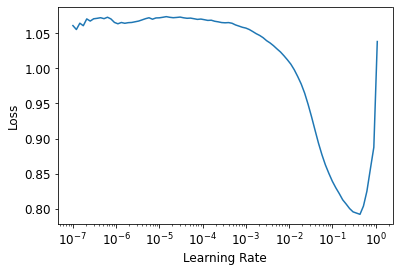

In [7]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

In [8]:
torch.cuda.is_available()

True

In [9]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.926053,0.622132,0.678422,00:44
1,0.524298,0.138304,0.956580,00:38
2,0.294859,0.115658,0.957954,00:39
3,0.193615,0.109741,0.961130,00:38
4,0.142037,0.102094,0.963927,00:39
5,0.111962,0.099736,0.963927,00:40
6,0.092556,0.095616,0.965965,00:41
7,0.078902,0.094329,0.967292,00:39
8,0.068848,0.092115,0.967482,00:38
9,0.062093,0.091427,0.967435,00:38


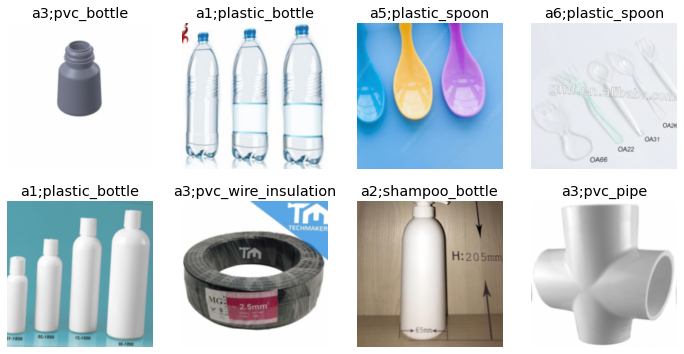

In [15]:
dls.train.show_batch(max_n=8, nrows=2)

In [41]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button()
out_pl = widgets.Output()
labels = [widgets.Label() for _ in range(10)]

def nice_label(cls, prob):
  t = cls[0]
  d = cls[1:]
  if t == 'a' and d.isdigit():
    cls = f'Plastic type: ({int(d)}) ' + {
        '00': 'missing or unreadable identifier',
        '01': 'PET - polyethylene terephthalate',
        '02': 'PE-HD - high-density polyethylene',
        '03': 'PVC - polyvinyl chloride',
        '04': 'PE-LD - low-density polyethylene',
        '05': 'PP - polypropylene',
        '06': 'PS - polystyrene',
        '07': 'Other'}[d.zfill(2)] + f" ({d})"
  else:
      cls = f"Similar to: {cls}"
  return f"{cls} ({prob*100:.4f}%)"

def on_click(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl:
        display(img.to_thumb(256, 256))
    pred, pred_idx, probs = learn.predict(img)
    probabilities = list(probs[pred_idx])
    img_labels = [nice_label(p, probabilities.pop()) for p in pred]
    for i, label in enumerate(labels):
        value = ''
        try:
            value = img_labels[i]
        except IndexError:
            pass
        label.value = value

btn_upload.observe(on_click, names=['data'])

In [42]:
display(VBox([widgets.Label('Select your image!'), btn_upload, out_pl, *labels]))

In [43]:
learn.export(f"duckduckgo.pkl")

(6.309573450380412e-08, 6.918309736647643e-06)

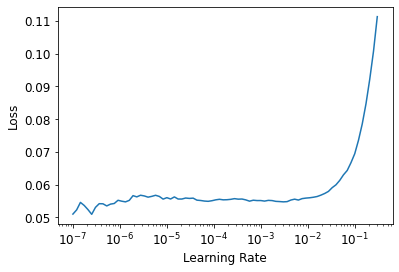

In [44]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

In [45]:
learn.fit_one_cycle(3, 6.918309736647643e-06)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.055730,0.091225,0.967529,00:39
1,0.055581,0.091407,0.967672,00:39
2,0.055629,0.091632,0.967245,00:45


In [46]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.055735,0.093098,0.967340,00:38


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.059411,0.101636,0.965776,00:48
1,0.054082,0.095947,0.967861,00:50
2,0.045294,0.092096,0.969473,00:50


In [47]:
learn.export(f"duckduckgo_0.092096.pkl")

In [48]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.036008,0.094508,0.969094,00:45


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.035455,0.092216,0.969520,00:46
1,0.032734,0.102428,0.967861,00:46
2,0.032337,0.107240,0.967719,00:45
3,0.030981,0.108176,0.968383,00:45
4,0.027475,0.110450,0.969094,00:46
5,0.023153,0.104879,0.969520,00:45
6,0.018254,0.104293,0.970326,00:46
7,0.015028,0.103126,0.970990,00:46
8,0.012739,0.103405,0.970753,00:46
9,0.011032,0.102710,0.970848,00:49


(9.12010818865383e-08, 6.309573450380412e-07)

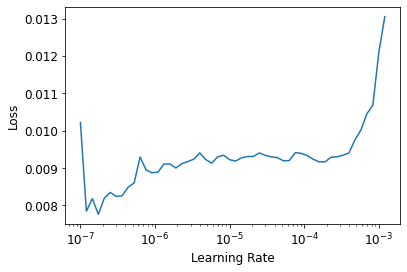

In [49]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

In [50]:
learn.fit_one_cycle(3, 6.309573450380412e-07)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.009448,0.102971,0.970990,00:47
1,0.009433,0.102892,0.970611,00:47
2,0.009298,0.102775,0.970705,00:47


(1.3182566908653825e-05, 1.3182567499825382e-06)

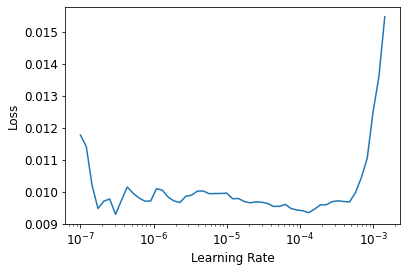

In [51]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

In [52]:
learn.fit_one_cycle(10, 1e-7)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.009632,0.102685,0.970753,00:44
1,0.009233,0.102500,0.970800,00:43
2,0.009601,0.103507,0.971369,00:43
3,0.009458,0.103604,0.970847,00:43
4,0.009318,0.103541,0.970753,00:44
5,0.009480,0.102802,0.970705,00:46
6,0.009696,0.102922,0.971037,00:44
7,0.009623,0.103052,0.970800,00:44
8,0.009495,0.102736,0.971037,00:44
9,0.009379,0.102963,0.971085,00:49
